In [7]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [8]:
WPI_xdf_path = "HCILab1-Group11.xdf"
CSL_xdf_path = "CSL_Laptop_Group11.xdf"

### View XDF Streams

In [9]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [10]:
view_xdf_streams(WPI_xdf_path)

Stream 2: Calculated effective sampling rate 26.4332 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2025-01-16T10:08:16-0500']})}
Stream Unicorn_HCILab1 (Stream ID: 1 with sampling rate 250.26578474445182)
Stream OBS_HCILab1 (Stream ID: 4 with sampling rate 30.000000343415618)
Stream OBS_HCILab2 (Stream ID: 2 with sampling rate 26.43315067888946)
Stream Unicorn_HCILab2 (Stream ID: 3 with sampling rate 239.03171515168378)
Stream OBS_CSL_Laptop (Stream ID: 5 with sampling rate 29.999868301940722)


In [11]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2025-01-16T16:08:27+0100']})}
Stream OBS_CSL_Laptop (Stream ID: 3 with sampling rate 30.000000298855728)
Stream Unicorn_CSL_Laptop (Stream ID: 4 with sampling rate 250.25663990474388)
Stream Unicorn_HCILab2 (Stream ID: 2 with sampling rate 239.00109228837445)
Stream Unicorn_HCILab1 (Stream ID: 1 with sampling rate 250.26860628532995)


WPI HCI Lab Streams:


Stream 2: Calculated effective sampling rate 26.4332 Hz is different from specified rate 30.0000 Hz.


Stream Unicorn_HCILab1 has 1053174 time stamps, starting with 209.08688431746512


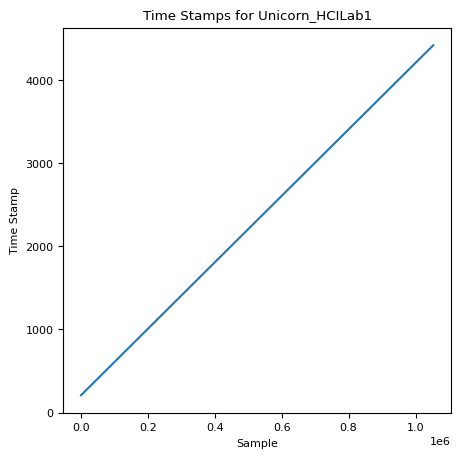

Stream OBS_HCILab1 has 126238 time stamps, starting with 209.44686320891068
Stream OBS_HCILab1 with time series (UNIX) begins with 1737040096.435
Stream OBS_HCILab2 has 106392 time stamps, starting with 197.593885266783
Stream OBS_HCILab2 with time series (UNIX) begins with 1737040096.086
Stream Unicorn_HCILab2 has 960785 time stamps, starting with 222.1347721104663


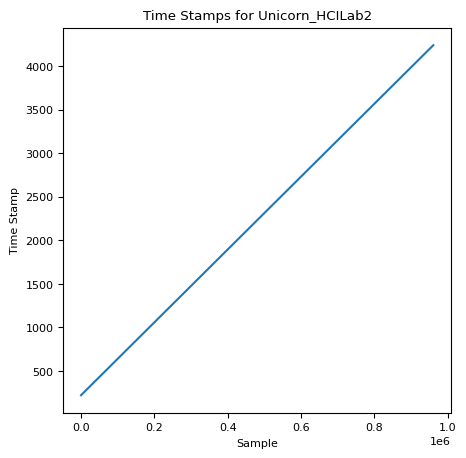

Stream OBS_CSL_Laptop has 126231 time stamps, starting with 209.608885645921
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1737040095.926

CSL Lab Streams:
Stream OBS_CSL_Laptop has 119203 time stamps, starting with 1164.4747946958407
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1737040107.826
Stream Unicorn_CSL_Laptop has 994381 time stamps, starting with 1164.3965081661245


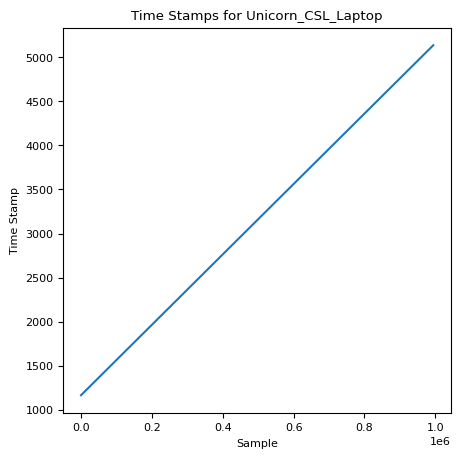

Stream Unicorn_HCILab2 has 951060 time stamps, starting with 1177.800193873091


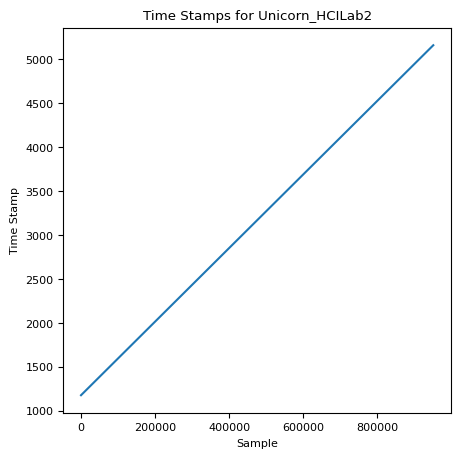

Stream Unicorn_HCILab1 has 994419 time stamps, starting with 1164.290975919913


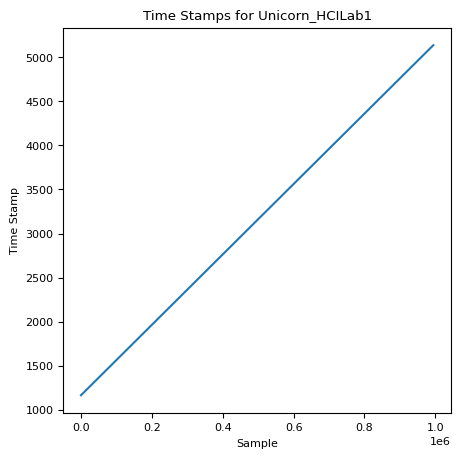

In [12]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")
        
        if "Unicorn" in stream_name:
            # plot the time stamps
            plt.rc('font', size=8)
            plt.figure(figsize=(5, 5))
            plt.plot(time_stamps)
            plt.xlabel('Sample')
            plt.ylabel('Time Stamp')
            plt.title(f"Time Stamps for {stream_name}")
            plt.show()

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

### Sync Streams!!

In [13]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1737040387.626
    end_unix_timestamp = 1737044002.593
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = start_EEG_index + round(frames)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
    
    return streams

In [14]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 2: Calculated effective sampling rate 26.4332 Hz is different from specified rate 30.0000 Hz.


In [15]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 1053174 time stamps and 1053174 time series
Time stamps: [209.08688431746512 ... 4417.304959402173]

Stream OBS_HCILab1 has 126238 time stamps and 126238 time series
Time stamps: [209.44686320891068 ... 4417.34681503991]
Time series (UNIX): [1737040096.435 ... 1737044304.335]

Stream OBS_HCILab2 has 106392 time stamps and 106392 time series
Time stamps: [197.593885266783 ... 4222.506397112957]
Time series (UNIX): [1737040096.086 ... 1737044095.053]

Stream Unicorn_HCILab2 has 960785 time stamps and 960785 time series
Time stamps: [222.1347721104663 ... 4241.618309110771]

Stream OBS_CSL_Laptop has 126231 time stamps and 126231 time series
Time stamps: [209.608885645921 ... 4417.294023924477]
Time series (UNIX): [1737040095.926 ... 1737044303.593]

CSL Lab Streams before syncing:

Stream OBS_CSL_Laptop has 119203 time stamps and 119203 time series
Time stamps: [1164.4747946958407 ... 5137.874755113064]
Time series (UNIX): [

In [16]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

In [17]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 903742 time stamps and 903742 time series
Time stamps: [500.6489130656205 ... 4111.7737818147525]

Stream OBS_HCILab1 has 108449 time stamps and 108449 time series
Time stamps: [500.6468598754634 ... 4115.58015182765]
Time series (UNIX): [1737040387.635 ... 1737044002.568]

Stream OBS_HCILab2 has 96021 time stamps and 96021 time series
Time stamps: [495.666895961635 ... 4128.230734890394]
Time series (UNIX): [1737040387.653 ... 1737044002.574]

Stream Unicorn_HCILab2 has 895402 time stamps and 895402 time series
Time stamps: [495.6675246330842 ... 4241.618309110771]

Stream OBS_CSL_Laptop has 126231 time stamps and 126231 time series
Time stamps: [209.608885645921 ... 4417.294023924477]
Time series (UNIX): [1737040095.926 ... 1737044303.593]

CSL Lab Streams AFTER syncing:

Stream OBS_CSL_Laptop has 108449 time stamps and 108449 time series
Time stamps: [1444.2747919084895 ... 5059.20808923007]
Time series (UNIX): [17370403

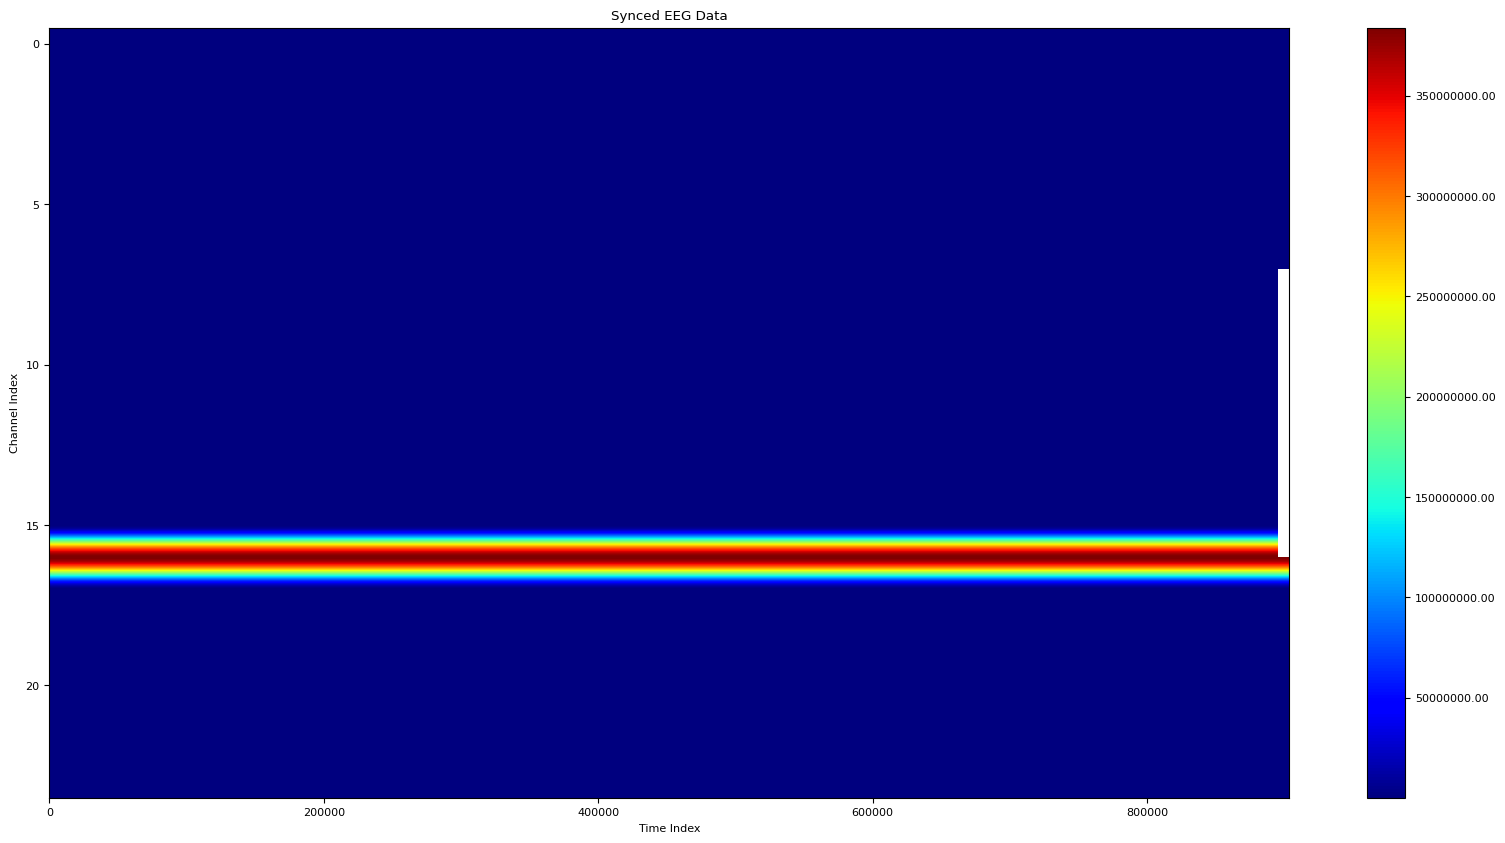

Min: 190142.265625
Max: 383931936.0
Mean: 16269802.287150025
Standard Deviation: 76783187.77079551


In [18]:
import scipy.io

# Disable scientific notation in NumPy globally
np.set_printoptions(suppress=True)

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 3 * 8)
synced_EEG_data = np.full((max_length, 3 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar(format='%.2f')  # Ensures color bar does not use scientific notation
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

print("Min:", np.nanmin(synced_EEG_data))
print("Max:", np.nanmax(synced_EEG_data))
print("Mean:", np.nanmean(synced_EEG_data))
print("Standard Deviation:", np.nanstd(synced_EEG_data))

# Download the EEG data as an .mat file
scipy.io.savemat('task_cutoff_EEG_data_11.mat', {'task_cutoff_EEG_data_11': synced_EEG_data})